# Attendance

[The link to SEAts](https://gold.seats.cloud/angular/#/lectures)

# 8 Introduction to deep learning for computer vision

- **Convolution & Pooling operations**
- **Data augmentation**
- **Feature extraction with a pretrained net**
- **Fine-tuning a pretrained net**

In [67]:
import os
import shutil
import pathlib
import zipfile
import kagglehub

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from IPython.core.magic import register_cell_magic

os.environ["KERAS_BACKEND"] = "jax"

import keras
import keras_hub

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Introduction to convnets

This topic introduces a new type of layer: the **convolutional layer**.

Convnets – models with convolutional layers – are first-call choices for computer vision DL applications (although the competition with Transformers is steep these days).

We will learn:

- What are convnets, how do they work?
- Build one and train it on with a small training set;
- Use of powerful pretrained convnets;
- Visualise what convnets learn.

We begin with a simple convnet for the MNIST task.

A few lines of code.

It easily outperforms our previous dense-layer models.

In [2]:
inputs = keras.Input(shape=(28, 28, 1)) # notice the functional syntax! ↓
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs) # ← we define the model by providing inputs and outputs

A stack of `Conv2D` and `MaxPooling2D` layers: we learn about these today.

A convnet accepts input tensors of shape (excluding the batch dimension):

```
(image_height, image_width, image_channels) # channels: RGB colors
```
Here:
```python
x = keras.Input(shape=(28, 28, 1)) # MNIST is b&w: 1 channel
```

Functional syntax with the `keras.Model`.

A `Model` is instantiated from:
- an input tensor (or list of input tensors) and
- an output tensor (or list of output tensors).

These class models are more flexible than the `Sequential` model of our earlier topics.

`keras.Sequential()` instantiates a model that requires exactly one input and one output.

`keras.Model()` models can have multiple inputs and outputs – more in Topic 7: Advanced Practices.

In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,234 (1.42 MB)

 Trainable params: 372,234 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

Every `Conv2D` and `MaxPooling2D` layer output is a 3D tensor of shape:
```
(height, width, channels)
```

Notice how the width and height dimensions shrink along the processing pipeline, just as the channels increase.

`Conv2D` layer parameters:

```python
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
```
64 channels, a 3 x 3 **kernel**, relu activation.

The final convolution output (of shape `(3, 3, 128)`) must be fed into a densely-connected classifier.

`Dense` layer classifiers process 1D vectors – the convnet output is a 3D tensor.

We `Flatten` our 3D output to 1D, and then add a `Dense` layer on top.

The `(3, 3, 128)` convnet output is flattened into a  `(3 * 3 * 128,) = (1152,) ` vector.

Then it is passed into a `Dense` layer with a `softmax` activation.


In [4]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy: {test_acc:.3f} ... (⌒_⌒;) ")

Test accuracy: 0.103 ... (⌒_⌒;) 


In [6]:
model.fit(
    train_images,
    train_labels,
    epochs=5,
    batch_size=64,
    verbose=0,
)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f} (¬‿¬ )") # better than dense nets with the same amount of params!

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9896 - loss: 0.0316
Test accuracy: 0.992 (¬‿¬ )


----

## The convolution operation

Previously, we built fully-connected (dense layered) feedforward networks.

The architecture does not match the **local structure** of the images.

Pixels that are far apart have the same influence as pixels that are close.

But images typically do have **local structure** (edges, corners, shading etc).

And these local patterns are **repeated** throughout the image.

Convolutional nets respect **translational invariance** of image detail.

That means: they can learn features **regardless of where they appear in the image**.

They are **smaller** than dense models and **faster** to train.

That is because the number of parameters can remain the same **no matter the size of the image**.

They are the natural choice for deep learning computer vision.

(At least until Transformers come along...)

Let's take our well-known MNIST sample: a 28 x 28 greyscale array, as an input.

Now, a unit/neuron in the first hidden (convolutional) layer is connected to patches of $9 = 3 x 3$ inputs  
(in the first layer: pixels, in general: neurons/units).

Each of those patches, when scanned by our kernel, is known as its **local receptive field**.

It is what the kernel 'sees' at any one point.

Each kernel element (a connection) is one weight, and there is a **single bias**. 10 learnable parameters.

The **kernel** is repeated by shifting it one pixel at a time (over many patches or **local receptive fields**).

Each time, the same operation occurs: an **element-wise product** between the layer weights and the patch, followed by a **sum** (then the bias is added).


<!-- <img style="float:right" src="images/convolutions/convolution-goodfellow-bengio.png" style="width: auto;"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/convolutions/convolution-goodfellow-bengio.png">


<small style="position:absolute;bottom:0;right:0">[Ian Goodfellow, Yoshua Bengio, Aaron Courville, *Deep Learning*, MIT Press, 2016, p. 334](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)</small>

<!-- <img style="float:right" src="images/convolutions/conv-1.gif" style="width: auto;"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/convolutions/conv-1.gif">

<small style="position:absolute;bottom:0;right:0">[Irhum Shafkat, Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)</small>

As the the kernel is moved across the image, being exposed to different patches (local receptive fields), its **weights remain the same**.

In a way it's as if we were 'summarising' local information (3x3) in one number (literally a *weighted* sum).

*This is the same operation as a blur in image processing or a filter in sound processing.*  

<!-- <img style="float:right" src="images/convolutions/conv-2.gif" style="width: auto;"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/convolutions/conv-2.gif">

<small style="position:absolute;bottom:0;right:0">Source: [Irhum Shafkat, Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)</small>

When we are dealing with multiple channels, the convolution layer will contain as many kernels as there are input channels.

<!-- <img style="float:right; height: 500px"  src="images/chollet/figure8.4.png"> -->
<img style="float: right; height: 500px"   src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/chollet/figure8.4.png">

<small style="position:absolute;bottom:0;right:0">[DLWP](https://deeplearningwithpython.io/chapters/chapter08_image-classification/#the-convolution-operation), Figure 8.4</small>

Note that you don't *have* to move by one! You can increase that parameter.

This is called the **stride**.

Here a stride of 2, where we skip every other position:

<!-- <img style="float:right" src="images/convolutions/conv-4.gif"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/convolutions/conv-4.gif">


<small style="position:absolute;bottom:0;right:0">Source: [Irhum Shafkat, Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1), originally from [Dumoulin and Visin, A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285) ([github](https://github.com/vdumoulin/conv_arithmetic))</small>

Note also that if you need the output of this operation to keep the dimensions the same, you need to **pad** the input (usually with zeros).

<!-- <img style="float:right" src="images/convolutions/conv-3.gif"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/convolutions/conv-3.gif">

<small style="position:absolute;bottom:0;right:0">Source: [Irhum Shafkat, Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1), originally from [Dumoulin and Visin, A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285) ([github](https://github.com/vdumoulin/conv_arithmetic))</small>

The (not so great) vocabulary for both of these is:
- `valid` (= no padding: only **valid** positions in the input are used);
- `same` (= with padding: the output dimension is the **same** as the input).

As you can see, the vanilla operation will reduce the size of the image.  
This is the equation for it (assuming a square input and and a square kernel):

$$
\bbox[5px,border:2px solid red]{
    output\_size = \frac{input\_size\ -\ kernel\_size + 2\times padding}{stride} + 1
}    
$$

If padding is zero and stride one, this simplifies to:


$$
 \bbox[5px,border:2px solid red]{
    output\_size = input\_size\ -\ kernel\_size + 1
}
$$


The weights and bias ($3 \times 3 + 1 = 10$ params in our example) do not change even though the local receptive field sweeps across the image.

Those weights and bias, the **kernel**'s, are *learnt* – they specialise in detecting a single **feature**.

What is a feature? Perhaps an edge? The beauty is: this emerges from training.

It can detect this same feature (edge) anywhere in the image – that's how the convolutional layer respects the **local image structure** (translational invariance).

You can think of this operation as runnning some sort of **detector** over the image.

One kernel (detector) will look for one specific feature. For instance, vertical edges:

<!-- <img style="float:right; height:500px" src="images/convolutions/conv-5-edge-detector.png"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/convolutions/conv-5-edge-detector.png">

<small style="position:absolute;bottom:0;right:0">Source: [Irhum Shafkat, Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)</small>

The result (filter) is a **feature map**, mapping the 28 x 28 input image features to a smaller, 24 x 24 dimensional 'image'.

You can think of this as a *geographical map*: the image is the actual territory, the *map* tells you where features are (beaches, rivers, treasure, dangers, etc.).

Your kernel scans the territory searching for a particular feature.

Finally, because we want to detect many different **features**, we repeat the process with **several kernels** on the same image.

*A colour image has three channels. You could view the feature maps as __one__ image with many channels*...

<!-- <img style="float:right" src="images/CNN.png" style="width: auto;"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/CNN.png">

<small style="position:absolute;bottom:0;right:0">Source: [Md Zahangir Alom et al., "A State-of-the-Art Survey on Deep Learning Theory
and Architectures", Researchgate](https://www.researchgate.net/figure/The-overall-architecture-of-the-Convolutional-Neural-Network-CNN-includes-an-input_fig4_331540139)</small>

```python
x = keras.layers.Conv2D(
    filters=64,        # filters/kernels: 64
    kernel_size=3,     # kernel: 3x3 | specify each axis with a tuple: (1,2)
    strides=2,         # strides: by how much you slide | tuples also work
    activation="relu", # activation after operation
    padding="same"     # padding: "same" or "valid"
)(x)
```

As usual, many more options and tweaks you can find in the [TF Keras reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

----

## The max-pooling operation

Convnets also contain pooling layers, which are basically just **downsampling**.

Pooling layers are usually used immediately after convolutional layers.

Pooling layers simplify the information from the preceding convolutional layer.

For instance, each unit in the pooling layer may summarize a 2 x 2 patch in the previous layer.

In *max-pooling*, a pooling unit simply outputs the **maximum activation** in the 2 × 2 input region.

There are 4 x 4 neurons in the depicted input layer;  
2 x 2 neurons in the pooling layer: the feature map is halved in size.


See [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D) for equations in all cases.

<!-- ![Francis max-pooling](images/convolutions/max-pooling.gif) -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/convolutions/max-pooling.gif">

<small style="position:absolute;bottom:0;right:0">Source: [Justin Francis, Visualizing convolutional neural networks, O'Reilly](https://www.oreilly.com/radar/visualizing-convolutional-neural-networks/)</small>

Max-pooling is applied to each feature map separately.

With convolution, the number of channels is transformed into a **different** number of feature maps.   
With max-pooling, each feature map is reduced in size (**same number of feature maps**).

<!-- <img style="float:right" src="images/CNN.png" style="width: auto;"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/CNN.png">


<small style="position:absolute;bottom:0;right:0">Source: [Md Zahangir Alom et al., "A State-of-the-Art Survey on Deep Learning Theory
and Architectures", Researchgate](https://www.researchgate.net/figure/The-overall-architecture-of-the-Convolutional-Neural-Network-CNN-includes-an-input_fig4_331540139)</small>

**Common pattern**

- 3 x 3 kernels, stride 1
- 2 x 2, max-pooling, stride 2

Also possible, but less common: *min-*, *average-* pooling.


Max-pooling is arguably preferential – the **maximal presence** of a feature is more informative.

Rather than risk diluting its presence by taking an average.

The intuition behind any type of pooling is similar: pooling is a way of **condensing information**.

Pooling not only **downsamples** (therefore less parameters) but it also **widens the effective receptive field** seen by the next layer.

*For example, in 2 x 2, stride 2 pooling, a 6 x 6 patch coming out of the previous conv layer is reduced to a 3 x 3 patch in the pooling layer. This 3 x 3 patch is seen by a single neuron in the next layer. The neuron's field of vision has increased from 3 x 3 to 6 x 6.*

In the figure, the neuron in layer 3 'sees' the whole image in layer 1 after the layer 2 downsampling:

<!-- <img  style="float:right" src="images/convolutions/receptive-field.png"> -->
<img style="float:right" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/convolutions/receptive-field.png">


<small style="position:absolute;bottom:0;right:0">[Xu et al., "MSF-Net: Multi-Scale Feature Learning Network for Classification of Surface Defects of Multifarious Sizes", ResearchGate](https://www.researchgate.net/figure/Schematic-diagram-of-the-receptive-field-in-CNNs_fig1_353545214)</small>

## Why convolutions?

Let's calculate the number of parameters in the first layers of our convnet:

In [7]:
inputs = keras.Input(shape=(28,28, 1))
x = keras.layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
model = keras.Model(inputs, x)
model.summary() # 320 params

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
32 * ((3 * 3) * 1 + 1) # number of params

320

Here's an example where we have more than one input channel.

In [9]:
inputs = keras.Input(shape=(28,28, 3))
x = keras.layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
model = keras.Model(inputs, x)
model.summary() # 320 params

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
32 * ((3 * 3) * 3 + 1) # number of params

896

For comparison: the input layer of our earlier MNIST model:

In [11]:
inputs = keras.Input(shape=(28*28,))
x = keras.layers.Dense(512, activation='relu')(inputs)
model = keras.Model(inputs, x)
model.summary() # 401'920 params

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       401,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,920 (1.53 MB)

 Trainable params: 401,920 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
f"{512 * (28 * 28 + 1):,}" # number of params

'401,920'

----

## Training a convnet on a small dataset

Small means dataset sizes of a few hundreds to a few tens of thousands of images.

A common computer vision situation.

In our case: a cat or a dog?

### The Dogs vs Cats dataset

4000 images of cats and dogs (2000 cats, 2000 dogs)

Split: 2000 images for training, 1000 for validation, 1000 for testing

This is a balanced binary classification problem.

The **commonsense baseline** prediction accuracy is 50%.

We will also train a small convnet on our 2000 training samples, without any regularization, to set a 'neural' baseline for what can be achieved.

#### Note

The original dataset contains 25,000 images of dogs and cats (12,500 from each class).

1. We will find that our second, CNN baseline classification accuracy of $\approx$72%.  
  (At that point, our main issue will be overfitting.)

2. We will fight overfitting with **data augmentation** and reach an accuracy of $\approx$79%.

3. Then we will review two more essential techniques applicable to small datasets:
  - **feature extraction** with a pretrained network => 96% accuracy;
  - **fine-tuning** a pretrained network => almost 97% final accuracy.
  
*(Chollet has a larger gap between the last two, I could not reproduce it. Please tell me if you can!)*

----

## DL and  small-data problems

Deep Learning requires masses of data? Basically correct.

It replaces time consuming manual feature engineering with automatic training  
– but the price is needing large datasets.

This is especially true for high-dimensional inputs.

What size of dataset is sufficient?

This depends on the size and depth of the network and the difficulty and the complexity of the task.

Training on a few hundred samples is feasible if:
- the network is small and regularised;  
- the task is simple.

Deep Learning models are fairly malleable: an image classification or speech-to-text model trained on a large-scale dataset can be reused on a significantly different problem with only minor changes.

Many pretrained computer vision models (usually trained on the ImageNet dataset) are now publicly available and can bootstrap powerful CV models with very little new data.

Remember me saying the **distributions** of the data must be the same in **training** and **production**?

Here we assume that the net has trained on enough data to covers what we need.

Despite being trained on a different image dataset, these pretrained models are useful because spatial features tend to be **generic** (edges, corners, etc).

We turn a *generalist* network into a *specialist* one.

----

## Downloading the data

<!-- ![Cats & Dogs dataset samples](images/chollet/figure8.8.png) -->
<img style="height:500px;" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/chollet/figure8.8.png">

[DMLCP](https://deeplearningwithpython.io/chapters/chapter08_image-classification/#downloading-the-data), Figure 8.8

The images are medium-resolution color JPEGs.

### Recommended Workflow

The dataset is available on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data), and DLWP has a procedure to download it in Colab:

1. Create a Kaggle account (free)
2. Go to [settings](https://www.kaggle.com/settings), create a token (`.json` file), download it locally and keep it somewhere safe. Then copy the access token inside it.
3. Verify your phone number within [Kaggle Profile Settings](https://www.kaggle.com/settings)
4. Go to the [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data) and join the competition.



#### Note



The [Dogs vs Cats dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) is available in the separate Tensorflow Dataset package, but there's a still unresolved bug in there, corrupted images...

### Data download & processing

**Note**: you need to use the **legacy API** token here, not the new one!

In [4]:
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [11]:
DATASET_DIR = pathlib.Path(kagglehub.competition_download("dogs-vs-cats"))
ORIG_TRAIN_DIR = DATASET_DIR / "train"
SMALL_DS_DIR = DATASET_DIR / "dogs_vs_cats_small"

In [19]:
with zipfile.ZipFile(DATASET_DIR / "train.zip", "r") as zip_ref:
    zip_ref.extractall(DATASET_DIR)

In [21]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        small_dir = SMALL_DS_DIR / subset_name / category
        os.makedirs(small_dir, exist_ok=True)
        if len(os.listdir(small_dir)) == end_index - start_index:
            # we reached the desired number of images
            return
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        # print(fnames)
        for fname in fnames:
            shutil.copyfile(src=ORIG_TRAIN_DIR / fname,
                            dst=small_dir / fname)
        else:
            print(f"found {small_dir}, done.")

In [22]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

TRAIN_DIR = SMALL_DS_DIR / "train"
VAL_DIR = SMALL_DS_DIR / "validation"
TEST_DIR = SMALL_DS_DIR / "test"
TRAIN_CATS_DIR = TRAIN_DIR  / "cat"
VAL_CATS_DIR = VAL_DIR  / "cat"
TEST_CATS_DIR = TEST_DIR  / "cat"
TRAIN_DOGS_DIR = TRAIN_DIR  / "dog"
VAL_DOGS_DIR = VAL_DIR  / "dog"
TEST_DOGS_DIR = TEST_DIR  / "dog"

# As a sanity check, let's count how many pictures we have in each sub-dataset:
print("-" * 40)
print('total training cat images:', len(os.listdir(TRAIN_CATS_DIR)))
print('total training dog images:', len(os.listdir(TRAIN_DOGS_DIR)))
print('total validation cat images:', len(os.listdir(VAL_CATS_DIR)))
print('total validation dog images:', len(os.listdir(VAL_DOGS_DIR)))
print('total test cat images:', len(os.listdir(TEST_CATS_DIR)))
print('total test dog images:', len(os.listdir(TEST_DOGS_DIR)))

found /root/.cache/kagglehub/competitions/dogs-vs-cats/dogs_vs_cats_small/train/cat, done.
found /root/.cache/kagglehub/competitions/dogs-vs-cats/dogs_vs_cats_small/train/dog, done.
found /root/.cache/kagglehub/competitions/dogs-vs-cats/dogs_vs_cats_small/validation/cat, done.
found /root/.cache/kagglehub/competitions/dogs-vs-cats/dogs_vs_cats_small/validation/dog, done.
found /root/.cache/kagglehub/competitions/dogs-vs-cats/dogs_vs_cats_small/test/cat, done.
found /root/.cache/kagglehub/competitions/dogs-vs-cats/dogs_vs_cats_small/test/dog, done.
----------------------------------------
total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 1000
total test dog images: 1000


----

## Building the model

Our convnet is a stack of alternating `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

The problem is more complex than MNIST (bigger images), we need a bigger convnet.

⇒ One more `Conv2D` + `MaxPooling2D` than in the first one:

- augments the capacity of the network;
- reduces the size of the feature maps: they are not too large when reaching the `Flatten` layer.

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.layers.Rescaling(1. / 255)(inputs) # ←---------------------------  PIXEL VALUE NORMALISATION!
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
# -------------------------------------------------------------------------- ↓ MORE LAYERS THAN BEFORE
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
# -------------------------------------------------------------------------- ↑ MORE CAPACITY & SMALLER FEATURE MAPS
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [34]:
model.summary(line_length=80)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)          │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ rescaling (Rescaling)             │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d (Conv2D)                   │ (None, 178, 178, 32)     │           896 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)      │ (None, 89, 89, 32)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)                 │ (None, 87, 87, 64)       │        18,496 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)    │ (None, 43, 43, 64)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)                 │ (None, 41, 41, 128)      │        73,856 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)    │ (None, 20, 20, 128)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)                 │ (None, 18, 18, 256)      │       295,168 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)    │ (None, 9, 9, 256)        │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)                 │ (None, 7, 7, 512)        │     1,180,160 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ global_average_pooling2d          │ (None, 512)              │             0 │
│ (GlobalAveragePooling2D)          │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                     │ (None, 1)                │           513 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 4,707,269 (17.96 MB)

 Trainable params: 1,569,089 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,138,180 (11.97 MB)

150 x 150 image input size (an arbitrary choice) is reduced to 5 x 5:

- the depth of the feature maps (number of channels/filters per layer) progressively increases (from 32 to 256);  
- the size of the feature maps decreases (from 148 x 148 to 5 x 5).

**Increasing depth** and **decreasing feature map size** is a common convnet architectural pattern.


**Binary classification problem**

The network ends in a single `sigmoid` unit and outputs: the probability that the network is looking at one class or the other.

**Metric**

We track the accuracy.

In [35]:
model.compile(
    loss="binary_crossentropy", # binary classification: one class or the other
    optimizer="adam",           # Adam as usual
    metrics=["accuracy"],       # our metric
)

----

## Data preprocessing

Our data must be vectorised into floating point tensors.

The data are JPEG files. The pipeline is then:

- read the picture files;
- decode the JPEG content to RGB grids of pixels;
- resize them to a shared size `(180, 180)`;
- convert to floating point tensors;
- (The rescaling of pixel values to $[0, 1]$ is dealt by the network itself, the `Rescaling` layer).

### Loading dataset splits

There are many processing helper tools in `tensorflow.keras.utils`.

Including an `image_dataset_from_directory` ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)), which can automatically turn image files on disk into batches of preprocessed tensors, assigning classes according to the directory structure!

```bash
$ tree -d 1 dogs-vs-cats
├── dogs_vs_cats_small
│   ├── test
│   │   ├── cat
│   │   └── dog
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── validation
│       ├── cat
│       └── dog

```

In [36]:
BATCH_SIZE = 64
IMAGE_SIZE = (180, 180)

train_dataset = keras.utils.image_dataset_from_directory(
    SMALL_DS_DIR / "train",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
validation_dataset = keras.utils.image_dataset_from_directory(
    SMALL_DS_DIR / "validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
test_dataset = keras.utils.image_dataset_from_directory(
    SMALL_DS_DIR / "test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


The batch size (samples per batch) is set to 32.

The generators yield batches of:
- 180 x 180 RGB images (shape: `(32, 180, 180, 3)`) and
- binary labels (shape: `(32,)`).

#### Understanding TensorFlow Dataset objects

TensorFlow datasets create iterables that can be fed to networks. There are many functionalities available, including batching, shuffling, custom filtering and transformations of datasets, caching and prefetching for memory optimisation, etc.


The official [tutorial](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [37]:
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [38]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [39]:
batched_dataset = dataset.batch(32)
for i, element in batched_dataset.enumerate():
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [40]:
reshaped_dataset = dataset.map(
    lambda x: tf.reshape(x, (4, 4)),
    num_parallel_calls=8
)
for i, element in reshaped_dataset.enumerate():
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [41]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)


- `.shuffle(buffer_size)`: shuffles elements within a buffer;
- `.map(callable)`: applies an arbitrary transformation to each element of the dataset (the function callable, which expects to take as input a single element yielded by the dataset);
- `.filter(callable)`: applies a transformation to remove certain elements;
- `.cache()`: caches elements the first time the dataset is iterated over;
-  `.prefetch(buffer_size)`: prefetches a buffer of elements in GPU memory to achieve better device utilization (while e.g. model computation is going on).

### Training

Note the use of the [`ModelCheckpoint` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to save our model just below!

In [42]:
MODELS_DIR = pathlib.Path("models")
MODELS_DIR.mkdir(exist_ok=True)

In [43]:
callbacks = [       #  ↓ a callback to save our best model!
    keras.callbacks.ModelCheckpoint(
        filepath = MODELS_DIR / "convnet_from_scratch.keras", # name of the file
        save_best_only=True,                                  # if False you can use save_freq to save every n epochs
        monitor="val_loss"                                    # what metric to monitor
    )
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=0,
)

del model

In [44]:
def plot_history(history):

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, constrained_layout=True, figsize=(10,3))

    ax1.plot(epochs, accuracy,label="Training accuracy")
    ax1.plot(epochs, val_accuracy, label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.legend()

    ax2.plot(epochs, loss, label="Training loss")
    ax2.plot(epochs, val_loss, label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.legend()
    plt.show()

Let's plot the loss and accuracy of the model over the training and validation data during training:

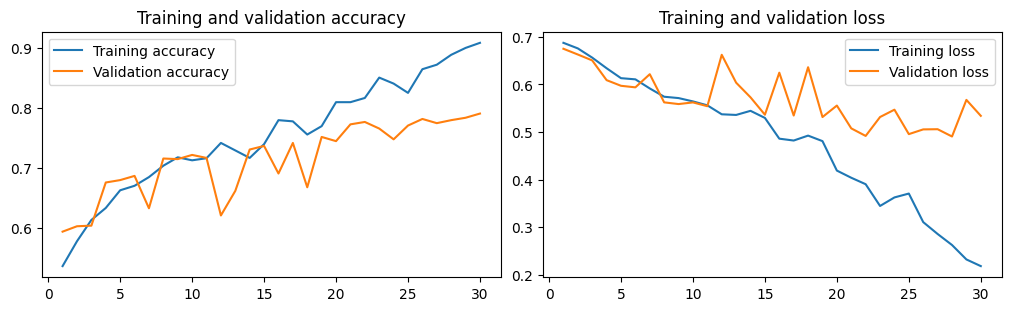

In [45]:
plot_history(history)

Overfitting!

Training accuracy increases, reaching nearly 100%; validation accuracy stalls at about 80%.

Training loss decreases to nearly zero; validation loss reaches its minimum in the first few epochs, then stalls.

Our test accuracy confirms this:


In [46]:
test_model = keras.models.load_model(MODELS_DIR / "convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")
del test_model

Test accuracy: 0.800


Overfitting is going to be a primary concern because we only have relatively few training samples (2000).

We have seen that *dropout* and *weight decay* (L2 regularisation) can mitigate overfitting.

Let's try a new scheme often used in DL computer vision models: **data augmentation**.

Highly recommended for CW2 if you work with image datasets!

----

## Data augmentation

Overfitting is caused by having too few samples.

Trained models are unable to generalize to new data.

Exposing a model to every possible aspect of the data distribution would cure overfitting  
– but we would (generally) need infinite datasets.

But what if we are limited to a small dataset?

We could *artificially* generate more training data from the existing data.

That is the approach of **data augmentation**.

In this case: apply a random transformations in order to generate credible new images  
(variations on existing ones).

Then, during training, our model will never see *exactly* the same image twice.

The model is exposed to more aspects of the data (but not different data) and may generalise better.

**Define a data augmentation stage to add to an image model**

The [official tutorial](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation).

In [49]:
data_augmentation_layers = [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
]

def data_augmentation(images, targets):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images, targets

augmented_train_dataset = train_dataset.map(
    data_augmentation,
    num_parallel_calls=8
)
augmented_train_dataset = augmented_train_dataset.prefetch(tf.data.AUTOTUNE)

**Displaying some randomly augmented training images**

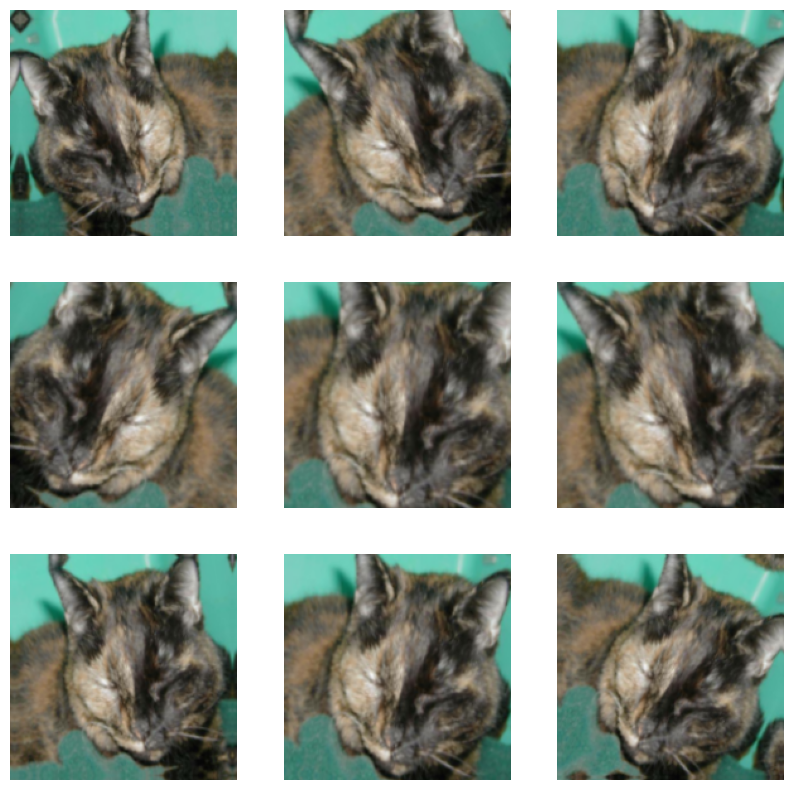

In [55]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images, _ = data_augmentation(images, None)   # each time we run data_augmentation on images
        ax = plt.subplot(3, 3, i + 1)                           # it returns a slightly modified version
        plt.imshow(keras.ops.convert_to_numpy(augmented_images[0]).astype("uint8"))
        plt.axis("off")

A new model will never see exactly the same image – is this infinite data?

No!

This is *not* generating new information, only *remix* old information, create *variations*.

So we might not completely eradicate overfitting.

We might need other regularisation techniques.

Let's add dropout to the classifier top end.

In [62]:
keras.utils.clear_session()

inputs = keras.Input(shape=(180, 180, 3))
x = keras.layers.Rescaling(1./255)(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x) # ←---------------------------------------- DROPOUT
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

Let's train our network using data augmentation and dropout:

In [63]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = MODELS_DIR / "convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    augmented_train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=0,
)
del model

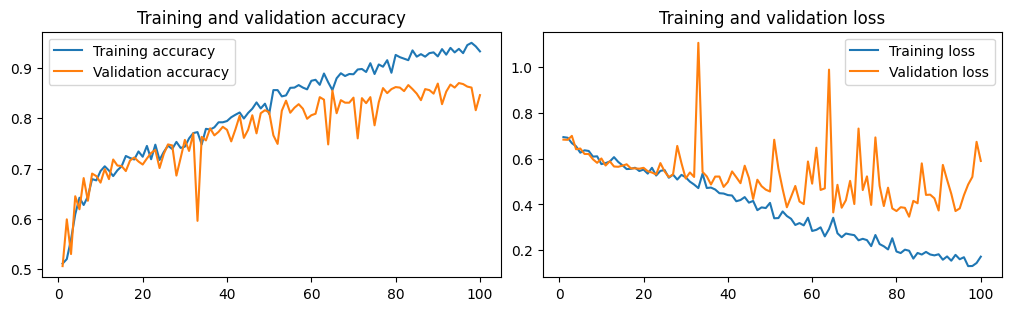

In [64]:
plot_history(history)

In [65]:
test_model = keras.models.load_model(
    MODELS_DIR / "convnet_from_scratch_with_augmentation.keras"
)
test_loss, test_acc = test_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")
del test_model

Test accuracy: 0.857


Other regularisation techniques and hyper-parameter tuning can push the accuracy higher by a few percents.

But the ultimate potential in training our own model from scratch is limited because of the size of our training set.

The next section shows how models that have been trained on different, larger, datasets, can be applied to the small-data problem.

----

## Leveraging a pretrained model

A pretrained network is simply a network that has been trained on a large dataset – typically, a large-scale image classification task – and saved for public use.

The pre-trained model, if it has been trained on a large and sufficiently general dataset, **will have learned the spatial feature hierarchy of real-world objects** (edges and corners, simple shapes, compound shapes).

Such a pretrained model would prove useful for many different computer vision problems – even for completely different classes from those of the original task.

For example, train a network on a dataset where the classes are mostly animals and everyday objects then, apply this trained network to identifying furniture.

It would not work as well as if you had a lot of furniture data to train on (same distribution), but it would be better than starting from scratch!

The ability of DL models to solve new, unseen problems distinguishes DL from older, shallow learning techniques.

It also makes DL very effective for small-data problems.

Let's consider a large convnet trained on the [ImageNet dataset](https://www.image-net.org/index.php).

(1.4 million labeled images and 1000 different classes)

ImageNet contains many animal classes, including different types of cats and dogs.

We can expect it to perform very well on our Dog vs. Cat problem.

`Keras` has several pretrained models - they have all been trained on ImageNet :

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Find them all [here](https://keras.io/api/applications/)).

We will use the Xception architecture.

It is a simple and widely used convnet architecture for ImageNet.

We'll talk more about this model in the next chapter.

There are two main ways to deploy a pre-trained network:

 - **feature extraction**
 - **fine-tuning**

----

## Feature extraction with a pretrained model

Feature extraction means using (extracting) the **learned representations** (features) of trained networks to find relevant features in new datasets.

Convnets are built in two parts:
- a *convolutional base* of pooling and conv layers;  
- densely-connected classifier.

The **base** weights and biases are *frozen* – held fixed, no gradient updates – and the original classifier is replaced with a new classifier that is more appropriate to the task in hand.

As a result:

  - the trained conv base *extracts features*;
  - the new classifier is trained to *interpret these features in terms of the new classes*.

Why only reuse the convolutional base? Why not use the densely-connected classifier as well?

Because representations learned by the convolutional base are likely to be  **generic concepts** (edges, corners, textures, etc) – that will apply to many real-world images.

Those learned by the classifier are *specific* and *non-spatial* (tailored for the original training set).

The generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model:
- early, lower, layers extract **local, highly generic feature** (such as visual edges, colours, textures);  
- higher layers extract **more abstract concepts** (such as 'cat ear' or 'dog eye');
- use the lower layers only, and not the entire base, for datasets that differ markedly from the original dataset of the trained model.

The constructor takes three arguments:

* `weights`: either `none`, `imagenet` or a path to a weights file;
* `include_top`: to include the three layer densely-connected 1000 class classifier;
* `input_shape`: shape of the input image tensor.

In [68]:
keras.utils.clear_session()

conv_base = keras_hub.models.Backbone.from_preset("xception_41_imagenet")

In [69]:
preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "xception_41_imagenet",
    image_size=(180, 180),
)

Here's the detail of the architecture of the Xception convolutional base.

In [70]:
conv_base.summary()

Model: "xception_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer[0][0] │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_residual_co… │ (None, None,      │      8,192 │ block1_conv2_act… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_residual_bn  │ (None, None,      │        512 │ block2_residual_… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_residual_add │ (None, None,      │          0 │ block2_pool[0][0… │
│ (Add)               │ None, 128)        │            │ block2_residual_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ block2_residual_

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

##### Note

You can see that our densely-connected classifier must accept the `(4, 4, 512)` output of the final feature map.

### Two options

1. Extract *then* train
2. Freeze *and* train

#### 1. Extract *then* train

  - run the convolutional base over Dogs vs Cats and save the outputs as a NumPy array;  
  - use the processed features as input to a standalone densely-connected classifier.

This is very fast because it only requires running the convolutional base once for every input image (the convolutional base is by far the most expensive part of the pipeline).

But this technique would prohibit data augmentation.

**Note**

This is similar to training a classifier on a dataset of *4 x 4 'images' each with 512 channels* (!).

#### 2. Freeze *and* train

  - **freeze** (= prevent training) the whole `conv_base`;  
  - add `Dense` layers on top of `conv_base`;  
  - train the whole thing end-to-end on the input data.

Every input image is going through the convolutional base every time it is seen by the model – we can use data augmentation.

But this technique is more computationally intensive.

---

### 1. Fast feature extraction without data augmentation

Let's look at option 1 (recording the outputs of `conv_base` on our data and using these outputs as inputs to a new model).

**Extracting the Xception features and corresponding labels**

In [80]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    # LOOP THROUGH THE ENTIRE DATASET
    for images, labels in dataset:
        # preprocess the images
        preprocessed_images = preprocessor(images)
        # run the images through the model
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# our feature datasets
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [81]:
train_features.shape # the shape of the current features: `(samples, 6, 6, 2048)`

(2000, 6, 6, 2048)

**Defining and training the densely connected classifier**

In [82]:
# ↓ DEFINITION OF OUR NEW MODEL ---------------------------
inputs = keras.Input(shape=(6, 6, 2048))
x = keras.layers.GlobalAveragePooling2D()(inputs)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
# ↑ -------------------------------------------------------
model = keras.Model(inputs, outputs)                     # finalise model by giving the inputs & outputs


model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath = MODELS_DIR / "feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train_features,
    train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks,
    verbose=0
)

del model

Training is very fast, less than 1 sec/epoch, since there are only two `Dense` layers.

Inspect training loss and accuracy:

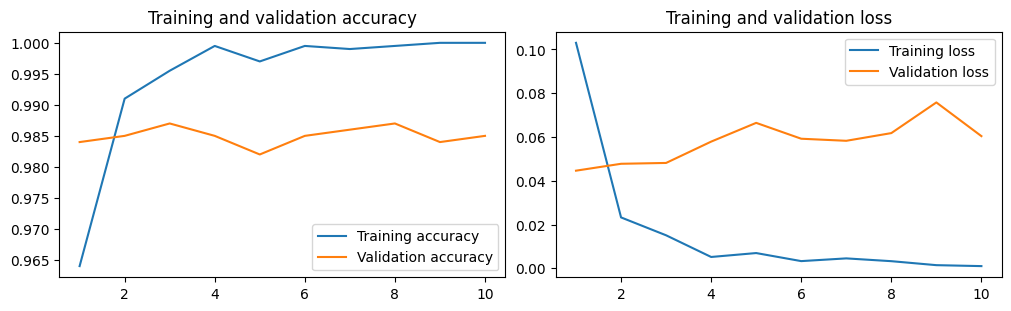

In [83]:
plot_history(history)

In [84]:
test_model = keras.models.load_model(MODELS_DIR / "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(
    test_features,
    test_labels,
    verbose=0
)
print(f"Test accuracy: {test_acc:.3f}")
del test_model

Test accuracy: 0.982


We attain about 98.2% validation accuracy.

Much better than our small model trained from scratch!

But the plots also indicate overfitting despite 50% dropout.

However, generator driven data augmentation is impossible with option 1.

Also, data augmentation is essential for preventing overfitting with small image datasets.

---

### 2. Feature extraction together with data augmentation

So let's now consider option 2 (freeze and train).

A layer is **frozen** if its weights cannot be updated during training.

The model or layer `trainable` attribute is set to `False`.

Freezing must take place before compilation.

**Note**

Why freezing? The `Dense` layers on top are randomly initialized. The very large weight updates happening at the beginning of training would be propagated through the network, effectively *destroying*/*damaging* the previously learned representations of the conv base.

<!-- <img style="height:700px" src="images/chollet/figure8.12.png"> -->
<img style="height:700px" src="https://raw.githubusercontent.com/jchwenger/AI/main/lectures/05/images/chollet/figure8.12.png">

[DLWP](https://deeplearningwithpython.io/chapters/chapter08_image-classification/#feature-extraction-with-a-pretrained-model), Figure 8.12

##### Feature extraction together with data augmentation

In [85]:
keras.utils.clear_session()

conv_base = keras_hub.models.Backbone.from_preset(
    "xception_41_imagenet",
    trainable=False, # ← FREEZE THE BASE
)

**Note**

Xception has 13 conv layers and each layer has a main weight tensor ($w$) and a bias tensor ($b$).

The dense classifier has two trainable layers – that's four more tensors of trainable parameters.

26 tensors of trainable parameters before freezing.

4 tensors after freezing.

**Printing the list of trainable weights before and after freezing**

In [86]:
conv_base.trainable = True
print("Number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

Number of trainable weights before freezing the conv base: 154


In [87]:
conv_base.trainable = False
print("Number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

Number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [89]:
# ↓ DEFINITION OF OUR NEW MODEL ---------------------------
inputs = keras.Input(shape=(180, 180, 3))
#   ↓ Xception-specific processing (scales inputs to appropriate range)
x = preprocessor(inputs)
#   ↓ OUR FROZEN BASE
x = conv_base(x)                                         # ← `keras` presents a
#   ↓ the rest of our net                                #   common interface for models and
x = keras.layers.GlobalAveragePooling2D()(x)             #   layers – models can be clicked
x = keras.layers.Dense(256)(x)                           #   into place as if they were layers!
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
# ↑ -------------------------------------------------------
model = keras.Model(inputs, outputs)                     #   finalise model by giving the inputs & outputs

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [90]:
model.summary() # 16 million params (but only 2 million trainable ones)!

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

16.8 million parameters in the convolutional base and 2 million dense classifier parameters.

In [91]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = MODELS_DIR / "feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    augmented_train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=0,
)

Inspect training: no overfitting – data augmentation has worked!

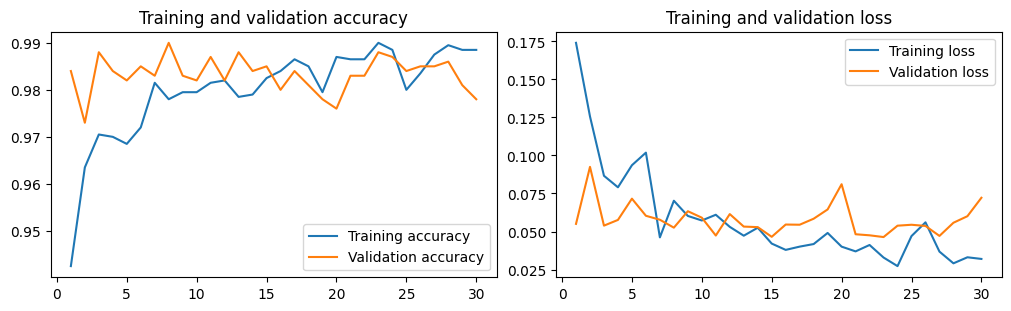

In [92]:
plot_history(history)

In [93]:
test_model = keras.models.load_model(MODELS_DIR / "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")
del test_model

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 318 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test accuracy: 0.985


We reach a validation accuracy of about 98.5%, even a bit better than option 1 (extract, then train) and again better than the small convnet trained from scratch.

But there is a final trick up the pretrained sleeve.

----

## Fine-tuning

Another widely used technique: unfreezing a few of the top layers of a frozen model base.

*Fine-tuning* adjusts the more abstract representations of the pretrained model in order to make them more relevant for the problem at hand.

#### Note

**One should only possible to fine-tune the top layers of the convolutional base *once the classifier on
top has already been trained*.**

Otherwise the error signal propagating back through the network would be too large and the representations previously learned by the unfrozen conv layers would be destroyed.

### Fine-tuning workflow

1. Add the custom classifier on top of the pretrained base
2. Freeze the base
3. Train the custom classifier
4. Unfreeze some base layers
5. Jointly train these layers and the custom classifier

We have already completed the first 3 steps, let's proceed with step 4.

In [94]:
conv_base.summary() # 20 million params, none trainable ones!

Model: "xception_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer[0][0] │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_residual_co… │ (None, None,      │      8,192 │ block1_conv2_act… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_residual_bn  │ (None, None,      │        512 │ block2_residual_… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_residual_add │ (None, None,      │          0 │ block2_pool[0][0… │
│ (Add)               │ None, 128)        │            │ block2_residual_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ block2_residual_

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

#### Note

Why not fine-tune more layers? Why not fine-tune the entire convolutional base?

Earlier conv base layers encode **generic features** (edges, textures) whilst higher layers encode more **specialised features**.

The generic features are expected to be present in any real-world image.

It is more useful to fine-tune the more specialized features.

#### Note

The convolutional base has 14.7M parameters – a large model with a very real chance of overfitting.

That is another reason not to fine-tune the entire base.

#### Reloading & finetuning

In [100]:
# In case you are doing this in installments, reload the feature extraction model
model = keras.models.load_model(MODELS_DIR / "feature_extraction_with_data_augmentation.keras")

Here, we will finetune the whole model, but here's how you would proceed to fine-tune only a few layers (usually the last ones of the model):
```python
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
```


In [101]:
model.compile(
    loss="binary_crossentropy",
    # SMALL LEARNING RATE – We should limit the magnitude of modifications to the
    # representations of the unfrozen layers. Large updates may damage these representations...
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = MODELS_DIR / "fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    augmented_train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=0,
)
del model

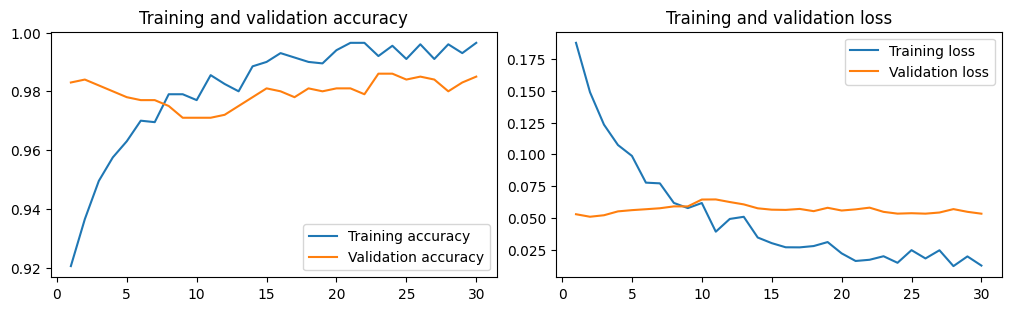

In [102]:
# note the scale!
plot_history(history)

In [103]:
model = keras.models.load_model(MODELS_DIR / "fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.980


### Save models to Google Drive


In [104]:
EXPORT = True

if EXPORT:
    # zip models
    !zip dogs-vs-cats.models.zip {MODELS_DIR}/*
    # connect to drive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy zip to drive (adjust folder as needed)
    !cp dogs-vs-cats.models.zip drive/MyDrive/gold/IS53024B-Artificial-Intelligence/models

updating: models/convnet_from_scratch.keras (deflated 16%)
updating: models/convnet_from_scratch_with_augmentation.keras (deflated 9%)
updating: models/feature_extraction.keras (deflated 7%)
updating: models/feature_extraction_with_data_augmentation.keras (deflated 8%)
updating: models/fine_tuning.keras (deflated 8%)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----

## Wrapping up

#### Convnets

- **Conv2D** operation, **kernel**, **filter**, **feature maps**
- **Stride**, **padding** (**same**/**valid**)
- **Max-Pooling** operation
- Far fewer parameters than dense networks!
- A prime-choice machine learning models for computer vision tasks

#### Workflows

- **Data augmentation**: helps with overfitting on small datasets
- **Feature extraction**: using features from a pretrained network also helps with overfitting, two flavours:
   -  only train the top classifier: fast but no augmentation
   -  train new top classifier with frozen net: more expensive, better
- **Fine-tune upper layers of pretrained net**: (only with a newly trained top classifier), even better performance